In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import re

# Create a folder
folders = ["Timetables"]
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [2]:
# Function to normalize input strings for consistent formatting
def normalize_course_str(course_str):
    """
    Normalizes course input strings to handle flexible formatting.
    Handles lift info and room number spacing.
    """
    # Fix lift info that was split by commas
    course_str = re.sub(r"\(Lift\s+(\d+),\s*(\d+)\)", r"(Lift \1/\2)", course_str)
    
    # Fix extra spaces between room and room number
    course_str = re.sub(r"Rm\s+(\d+)", r"Rm\1", course_str)
    
    # Clean up whitespace around commas
    parts = [part.strip() for part in course_str.split(",")]
    return ",".join(parts)

# Input the time slots of courses (now with flexible formatting support)
PHYS4191 = ["LA2, Yang Sen, Tue 13:30-16:20 Rm 6131 (Lift 19, 22), Thu 13:30-16:20 Rm 6131 (Lift 19, 22)"]
PHYS5210 = ["L1, Dai Xi, Mon 14:00-15:50 Rm 1409 (Lift 25-26), Fri 09:30-11:20 Rm 1409 (Lift 25-26)"]
PDEV6771 = ["T1, NA, Mon 16:00-17:50 LTK"]

# Normalize the input strings
PHYS4191 = [normalize_course_str(slot) for slot in PHYS4191]
PHYS5210 = [normalize_course_str(slot) for slot in PHYS5210]
PDEV6771 = [normalize_course_str(slot) for slot in PDEV6771]

# List of courses
courses = [PHYS4191, PHYS5210, PDEV6771]
courses_label = ["PHYS4191 (TA)", "PHYS5210", "PDEV6771"]

# Semester
sem = "Year 2 Fall"

# Number of top timetables
top = 10

In [3]:
# Define a dictionary that maps weekdays to corresponding numerical values
weekdays = {"Mon": 100, "Tue": 200, "Wed": 300, "Thu": 400, "Fri": 500, "Sat": 600, "Sun": 700}

# Function to extract the section from a given time slot
def get_section(slot):
    return slot.split(",")[0]

# Function to extract the instructor from a given time slot
def get_instructor(slot):
    return slot.split(",")[1]

# Function to extract the time range from a given time slot
def get_time(slot):
    parts = slot.split(",")
    return parts[2:] if len(parts) > 2 else []

# Convert a time range in the format "hh:mm-hh:mm" to decimal representation
def range_to_decimal(time_range):
    start_time, end_time = time_range.split("-")
    start_hours, start_minutes = map(int, start_time.split(":"))
    end_hours, end_minutes = map(int, end_time.split(":"))
    return start_hours + start_minutes / 60, end_hours + end_minutes / 60

# Check if there is any overlap between two time slots
def check_overlap(time1, time2):
    for t1 in time1:
        parts1 = t1.split()
        day1, time_range1 = parts1[0], parts1[1]
        start1, end1 = range_to_decimal(time_range1)
        day_offset1 = weekdays[day1]
        
        for t2 in time2:
            parts2 = t2.split()
            day2, time_range2 = parts2[0], parts2[1]
            start2, end2 = range_to_decimal(time_range2)
            day_offset2 = weekdays[day2]
            
            # Same day check first (most efficient)
            if day_offset1 == day_offset2:
                # Check time overlap: two intervals overlap if max(start1,start2) < min(end1,end2)
                if max(start1, start2) < min(end1, end2):
                    return True
    return False

# Check if there is any overlap among multiple time slots
def check_overlap_multiple(times):
    # Early return for single or no time slots
    if len(times) <= 1:
        return False
    
    # Generate all possible combinations of time slots
    for time_pair in itertools.combinations(times, 2):
        # Check if there is any overlap between each pair of time slots
        if check_overlap(*time_pair):
            return True
    return False

In [4]:
# Generate all possible timetables based on courses
timetables = []
for timetable in itertools.product(*courses):
    times = [get_time(course) for course in timetable]

    # Check for overlap in the timetable
    if not check_overlap_multiple(times):
        timetables.append(list(timetable))

print(f"The number of possible timetables is {len(timetables)}.\n")

# Calculate durations, start times, and end times for each day
def calculate_time_stats(timetable):
    days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
    durations = [0, 0, 0, 0, 0]
    start_times = [0, 0, 0, 0, 0]
    end_times = [0, 0, 0, 0, 0]
    for slot in timetable:
        for t in slot.split(",")[2:]:
            parts = t.split()
            day, time_range = parts[0], parts[1]
            index = days.index(day)
            start_time, end_time = range_to_decimal(time_range)
            durations[index] += end_time - start_time
            if start_times[index] == 0 or start_time < start_times[index]:
                start_times[index] = start_time
            if end_times[index] == 0 or end_time > end_times[index]:
                end_times[index] = end_time
    return durations, start_times, end_times

# Calculate the score for a timetable
def get_score(timetable):
    score = 100
    weight_d = 5
    day_off = 15
    weight_s = 5
    weight_e = 5
    durations, start_times, end_times = calculate_time_stats(timetable)

    for duration in durations:
        if duration > 5:
            score -= (duration - 5) * weight_d
        if duration == 0:
            score += day_off
    for start_time in start_times:
        if 0 < start_time < 11:
            score -= weight_s * (11 - start_time)
    for end_time in end_times:
        if 0 < end_time and end_time > 17.5:
            score -= weight_e * (end_time - 17.5)
    return score

# Calculate the score for each timetable and store the index-score tuples
scores = []
for i, timetable in enumerate(timetables):
    score = get_score(timetable)
    scores.append((i, score))

# Sort the timetables in descending order based on scores
scores.sort(key=lambda x: x[1], reverse=True)
timetables_sorted = [timetables[index] for index, score in scores]

# Calculate the rank for a timetable
def get_rank(timetable):
    global scores
    rank = None  # Initialize the rank variable with a default value
    for i, (index, score) in enumerate(scores):
        if score == get_score(timetable):
            rank = i + 1
            break
    return rank

# Print the top timetables with their scores
for i, timetable in enumerate(timetables_sorted[:top]):
    print(f"Timetable {i+1}: {timetable}")
    durations, start_times, end_times = calculate_time_stats(timetable)
    print(f"Durations: {durations}")
    print(f"Start times: {start_times}")
    print(f"End times: {end_times}")
    print(f"Score: {scores[i][1]}\n")

The number of possible timetables is 1.

Timetable 1: ['LA2,Yang Sen,Tue 13:30-16:20 Rm6131 (Lift 19/22),Thu 13:30-16:20 Rm6131 (Lift 19/22)', 'L1,Dai Xi,Mon 14:00-15:50 Rm1409 (Lift 25-26),Fri 09:30-11:20 Rm1409 (Lift 25-26)', 'T1,NA,Mon 16:00-17:50 LTK']
Durations: [3.666666666666666, 2.833333333333332, 0, 2.833333333333332, 1.833333333333334]
Start times: [14.0, 13.5, 0, 13.5, 9.5]
End times: [17.833333333333332, 16.333333333333332, 0, 16.333333333333332, 11.333333333333334]
Score: 105.83333333333334



In [5]:
# Save the top timetables with their scores to a text file
with open(f"timetables ({sem}).txt", "w") as file:
    for i, timetable in enumerate(timetables_sorted[:top]):
        file.write(f"Timetable {i+1}: {timetable}\n")
        durations, start_times, end_times = calculate_time_stats(timetable)
        file.write(f"Durations: {durations}\n")
        file.write(f"Start times: {start_times}\n")
        file.write(f"End times: {end_times}\n")
        file.write(f"Score: {scores[i][1]}\n\n")

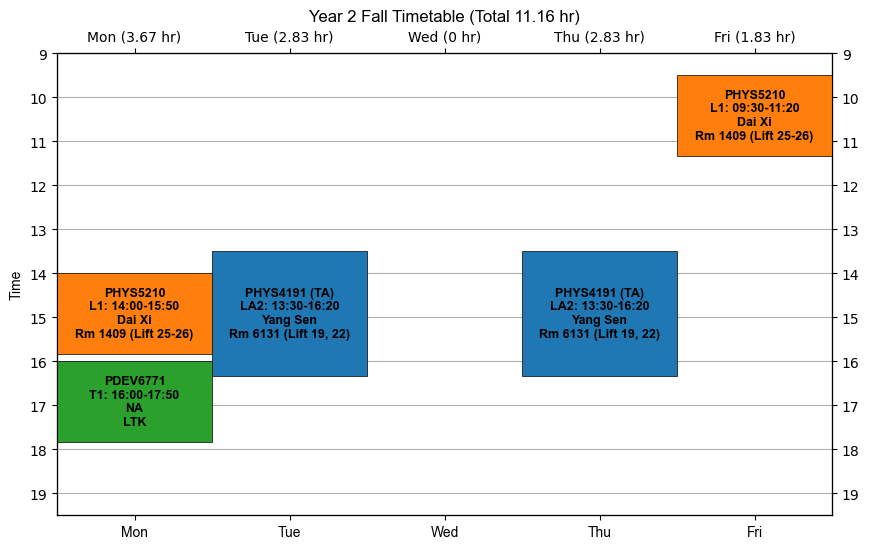

In [6]:
# Visualize timetables
def visualize(timetables, index=True, name=False):
    for i, timetable in enumerate(timetables):
        durations, start_times, end_times = calculate_time_stats(timetable)
        durations = [round(duration, 2) for duration in durations]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)

        # Set Axis
        ax.yaxis.grid()
        ax.set_xlim(0.5, 5.5)
        ax.set_ylim(19.5, 9)
        ax.set_xticks(range(1, 6))
        ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri"], fontname="Arial")
        ax.set_yticks(range(9, 20))
        ax.set_yticklabels([str(tick) for tick in range(9, 20)])
        ax.set_ylabel("Time", fontname="Arial")

        # Set Second Axis
        ax2 = ax.twiny().twinx()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim(ax.get_ylim())
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels([f"Mon ({durations[0]} hr)", f"Tue ({durations[1]} hr)", f"Wed ({durations[2]} hr)", f"Thu ({durations[3]} hr)", f"Fri ({durations[4]} hr)"], fontname="Arial")
        ax2.set_yticks(range(9, 20))
        ax2.set_yticklabels([str(tick) for tick in range(9, 20)])

        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        for j, slot in enumerate(timetable):
            course = courses_label[j]
            section = get_section(slot)
            instructor = get_instructor(slot)
            color = colors[j]
            
            # Iterate through all time slots for this course
            time_slots = get_time(slot)
            for time_str in time_slots:
                parts = time_str.split()
                day, time_range = parts[0], parts[1]
                room = " ".join(parts[2:]) if len(parts) > 2 else ""
                
                # Format room label
                if room.startswith("Rm"):
                    if "(Lift " in room:
                        # Extract room number and lift info
                        room_part = room.split(" (Lift ")[0]
                        lift_part = room.split(" (Lift ")[1]
                        room_number = room_part[2:]  # Remove "Rm"
                        
                        # Replace / with , in lift info and close parenthesis
                        lift_info = lift_part.replace("/", ", ").rstrip(")")
                        room = f"Rm {room_number} (Lift {lift_info})"
                    else:
                        # Just add space after Rm
                        room = f"Rm {room[2:]}"
                
                day = weekdays[day] / 100
                start_time, end_time = range_to_decimal(time_range)
                label = f"{course}\n{section}: {time_range}\n{instructor}\n{room}"
                plt.fill_between([day - 0.5, day + 0.5], [start_time, start_time], [end_time, end_time], color=color, edgecolor="k", linewidth=0.5)
                # Label the time slot
                plt.text(day, (start_time + end_time) * 0.5, label, ha="center", va="center", fontsize=9, fontname="Arial", fontweight="bold")

        plt.title(f"{sem} Timetable (Total {sum(durations)} hr)", fontname="Arial")
        if index == True:
            plt.savefig(f"Timetables/{sem.replace(' ', '').lower()}timetable{i+1}.png", dpi=300)
        elif index == False:
            plt.savefig(f"Timetables/{sem.replace(' ', '').lower()}timetable{name}.png", dpi=300)
        plt.show()

visualize(timetables_sorted[:top])